## Imports and Setup

In [1]:
import os
import sys
sys.path.insert(0, "../utils/")
import geoutils
import cnn_utils
import config

import pandas as pd
import numpy as np
import geopandas as gpd

import torch
import torchsummary

pd.set_option('mode.chained_assignment', None)
%load_ext autoreload
%autoreload 2

## Load Dataset

{'BLUE_TARP': 0, 'CONCRETE_CEMENT': 1, 'HEALTHY_METAL': 2, 'INCOMPLETE': 3, 'IRREGULAR_METAL': 4}
{'BLUE_TARP': 0, 'CONCRETE_CEMENT': 1, 'HEALTHY_METAL': 2, 'INCOMPLETE': 3, 'IRREGULAR_METAL': 4}


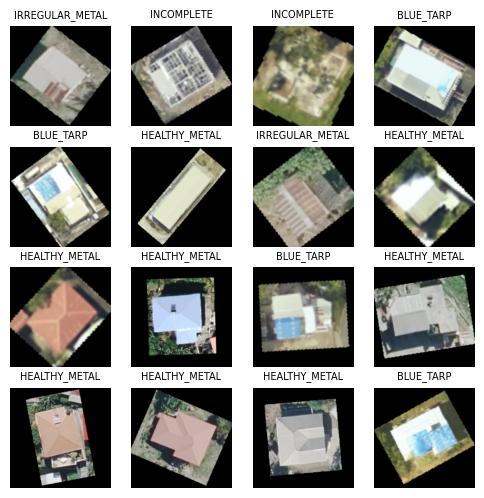

In [6]:
c = config.create_config("../configs/config_01.yaml")
phases = ["train", "test"]
c = {key: '.' + value if 'dir' in key else value for key, value in c.items()}

data, data_loader, classes = cnn_utils.load_dataset(
    config=c, phases=phases
)   
cnn_utils.visualize_data(data, data_loader, phase='train')

## Load Model

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model, criterion, optimizer, scheduler = cnn_utils.load_model(
    n_classes=len(classes),
    model_type=c["model"],
    pretrained=c["pretrained"],
    scheduler_type=c["scheduler"],
    optimizer_type=c["optimizer"],
    lr=c["lr"],
    momentum=c["momentum"],
    gamma=c["gamma"],
    step_size=c["step_size"],
    patience=c["patience"],
    dropout=c["dropout"],
    device=device,
    n_channels=1
)
torchsummary.summary(model, (1, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           3,136
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,